In [1]:
!python3 -V
import torch

print(f'torch.__version__: {torch.__version__}')

Python 3.10.12
torch.__version__: 2.1.0+cu121


In [2]:
import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile

def get_data_from_url(path_to_folder: str):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://disk.yandex.ru/d/tdC6HU4NjoIW2g'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    response = requests.get(download_url)
    zipfile = ZipFile(BytesIO(response.content))
    zipfile.extractall(path=path_to_folder)

path_to_data = "./data/"
get_data_from_url(path_to_data)

In [5]:
import tarfile
import os
import numpy as np

path_to_folder_with_archives = "./data/test/"

for root, _, files in os.walk(path_to_folder_with_archives):
    for file in files:
        if file.endswith(".gz"):
            path_to_tar = os.path.join(
                path_to_folder_with_archives,
                file
            )

            with tarfile.open(path_to_tar) as archive:
                members = [
                    member for member
                    in archive.getmembers()
                    if member.isfile()
                ]

                for m in members:
                    m.name = os.path.basename(m.name)

                archive.extractall(
                    path=os.path.join(
                        path_to_folder_with_archives,
                        "files"
                    ),
                    members=members
                )

In [6]:
import tarfile
import os
import numpy as np

path_to_folder_with_archives = "./data/train/"

for root, _, files in os.walk(path_to_folder_with_archives):
    for file in files:
        if file.endswith(".gz"):
            path_to_tar = os.path.join(
                path_to_folder_with_archives,
                file
            )

            with tarfile.open(path_to_tar) as archive:
                members = [
                    member for member
                    in archive.getmembers()
                    if member.isfile()
                ]

                for m in members:
                    m.name = os.path.basename(m.name)

                archive.extractall(
                    path=os.path.join(
                        path_to_folder_with_archives,
                        "files"
                    ),
                    members=members
                )

In [ ]:
!pip3 install wandb torch_ema denoising_diffusion_pytorch opencv-python

## Dataset

In [8]:
import numpy as np

from torchvision.datasets import MNIST, CelebA, OxfordIIITPet
from torch.utils.data import DataLoader, Dataset
from typing import Generator, Tuple, Dict, Optional, Union
from torch import Tensor
from cv2 import resize


def preprocess_image(image: "PIL.Image") -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = resize(image, (128, 128))
    return np.array(image, dtype=np.float32) / 127.5 - 1

def preprocess_np_array(image: np.ndarray) -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = resize(image, (128, 128))
    return np.array(image, dtype=np.float32) / 127.5 - 1

def postprocess_image(image: torch.Tensor) -> torch.Tensor:
    image = image.cpu().detach()
    image = (image + 1) * 127.5
    image = torch.clip(image, 0, 255)
    return image

In [9]:
import os
from tqdm import tqdm
from logging import getLogger
from torchvision.transforms import functional as TV_F
from tqdm.contrib.logging import logging_redirect_tqdm
import numpy as np
import random

logger = getLogger(__name__)

PATH_TO_TRAIN_DATA = "./data/train/"
PATH_TO_TEST_DATA = ".data/test/"

class WeatherFieldsDataset(Dataset):
    def __init__(self, train: bool = True):
        """
        Retrieves all npy tensors from path_to_data folder as dictionary by matching there names.
        """
        if train:
          path_to_data = PATH_TO_TRAIN_DATA
        else:
          path_to_data = PATH_TO_TEST_DATA

        date_idx_to_file_pathes = {}

        path = os.path.abspath(path_to_data)

        logger.info("Creating dataset. ")
        with logging_redirect_tqdm():
            for root, _, files in tqdm(os.walk(path)):
                for file in files:
                    if file.endswith("npy"):
                        if "high_res" in file:
                            hr_file_name = file
                            hr_file_name = hr_file_name.replace("_high_res_", "_")
                            hr_file_name = hr_file_name.replace(".npy", "")
                            _, date, number = hr_file_name.split("_")
                            index = int("".join(date.split("-")) + number)
                            if index in date_idx_to_file_pathes:
                                date_idx_to_file_pathes[index]['hr'] = os.path.join(
                                    root,
                                    file
                                )
                            else:
                                date_idx_to_file_pathes[index]= {
                                    'hr':os.path.join(
                                        root,
                                        file
                                    )
                                }
                        else:
                            lr_file_name = file
                            lr_file_name = lr_file_name.replace("_low_res_", "_")
                            lr_file_name = lr_file_name.replace(".npy", "")
                            _, date, number = lr_file_name.split("_")
                            index = int("".join(date.split("-")) + number)
                            if index in date_idx_to_file_pathes:
                                date_idx_to_file_pathes[index]['lr'] = os.path.join(
                                    root,
                                    file
                                )
                            else:
                                date_idx_to_file_pathes[index]= {
                                    'lr':os.path.join(
                                        root,
                                        file
                                    )
                                }

        self.date_idx_to_file_pathes = date_idx_to_file_pathes
        self.sorted_date_idx = list(date_idx_to_file_pathes.keys())
        self.sorted_date_idx.sort()

    def __len__(self):
        return len(self.sorted_date_idx)

    def __getitem__(self, index) -> Dict[str, torch.TensorType]:
        date_idx = self.sorted_date_idx[index]

        lr_file_path = self.date_idx_to_file_pathes[date_idx]['lr']
        hr_file_path = self.date_idx_to_file_pathes[date_idx]['hr']

        lr_image = preprocess_np_array(np.load(lr_file_path))
        hr_image = preprocess_np_array(np.load(hr_file_path))

        lr_image = np.transpose(lr_image, (2, 0, 1))
        hr_image = np.transpose(hr_image, (2, 0, 1))

        lr_image = Tensor(lr_image)
        hr_image = Tensor(hr_image)

        if random.random() < 0.5:
            lr_image = TV_F.hflip(lr_image)
            hr_image = TV_F.hflip(hr_image)

        if random.random() < 0.5:
            lr_image = TV_F.vflip(lr_image)
            hr_image = TV_F.vflip(hr_image)

        return {
            'low_resolution_images' : lr_image,
            'high_resolution_images' : hr_image
        }

In [10]:
class MnistDataset(Dataset):
    def __init__(self, train: bool = True):
        super().__init__()
        self.mnist = MNIST(
            'data',
            train=train,
            download=True
        )

    def __len__(self) -> int:
        return len(self.mnist)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        image, target = self.mnist[index]
        image = preprocess_image(image)

        size_reduction_coefficient = 4
        downsampling_scale = (
            1/size_reduction_coefficient,
            1/size_reduction_coefficient
        )
        upsampling_scale = (
            size_reduction_coefficient,
            size_reduction_coefficient
        )

        high_resolution_image = Tensor(image)[None, None]

        low_resolution_image = torch.nn.functional.interpolate(
            input=high_resolution_image,
            scale_factor=downsampling_scale,

        )
        upsampled_low_resolution_image = torch.nn.functional.interpolate(
            input=low_resolution_image,
            scale_factor=upsampling_scale,

        )

        return {
            "low_resolution_images": upsampled_low_resolution_image[0],
            "high_resolution_images": high_resolution_image[0],
        }

In [11]:
class OxfordIIITPetDataset(Dataset):
    def __init__(self, train: bool = True):
        super().__init__()
        if train:
          split = "trainval"
        else:
          split = "test"

        self.data = OxfordIIITPet(
            'data',
            split=split,
            download=True
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        image, target = self.data[index]
        image = preprocess_image(image)
        image = np.transpose(image, (2, 0, 1))

        size_reduction_coefficient = 4
        downsampling_scale = (
            1/size_reduction_coefficient,
            1/size_reduction_coefficient
        )
        upsampling_scale = (
            size_reduction_coefficient,
            size_reduction_coefficient
        )

        high_resolution_image = Tensor(image)[None]


        low_resolution_image = torch.nn.functional.interpolate(
            input=high_resolution_image,
            scale_factor=downsampling_scale,

        )
        upsampled_low_resolution_image = torch.nn.functional.interpolate(
            input=low_resolution_image,
            scale_factor=upsampling_scale,

        )

        return {
            "low_resolution_images": upsampled_low_resolution_image[0],
            "high_resolution_images": high_resolution_image[0],
        }

In [12]:
class CelebADataset(Dataset):
    def __init__(self, train: bool = True):
        super().__init__()
        if train:
          split = "train"
        else:
          split = "test"

        self.celeba = CelebA(
            'data',
            split=split,
            download=True
        )

    def __len__(self) -> int:
        return len(self.celeba)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        image, target = self.celeba[index]
        image = preprocess_image(image)

        size_reduction_coefficient = 4
        downsampling_scale = (
            1/size_reduction_coefficient,
            1/size_reduction_coefficient
        )
        upsampling_scale = (
            size_reduction_coefficient,
            size_reduction_coefficient
        )

        high_resolution_image = Tensor(image)[None, None]

        low_resolution_image = torch.nn.functional.interpolate(
            input=high_resolution_image,
            scale_factor=downsampling_scale,

        )
        upsampled_low_resolution_image = torch.nn.functional.interpolate(
            input=low_resolution_image,
            scale_factor=upsampling_scale,

        )

        return {
            "low_resolution_images": upsampled_low_resolution_image[0],
            "high_resolution_images": high_resolution_image[0],
        }

In [13]:
def dict_to_device(dct: Dict[str, Tensor], device: torch.device) -> Dict[str, Tensor]:
    return {k: v.to(device) for k, v in dct.items()}


def get_images_generator(
    dataset = MnistDataset(train=True),
    batch_size: int = 128,
    num_workers: int = 0,
    shuffle: bool = True,
    drop_last: bool = True
) -> Generator[Dict[str, Tensor], None, None]:
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=drop_last
    )
    while True:
        yield from loader

100%|██████████| 9912422/9912422 [00:00<00:00, 38846655.97it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33658153.33it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 80298761.09it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19864993.50it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [14]:
def check_generator(batch_size: int = 128, channels = 1):
    generator = get_images_generator(
        dataset=WeatherFieldsDataset(train=True),
        batch_size=batch_size
    )
    batch_dict = next(generator)
    assert batch_dict['low_resolution_images'].shape == (batch_size, channels, 128, 128), \
    batch_dict['low_resolution_images'].shape
    assert batch_dict['high_resolution_images'].shape == (batch_size, channels, 128, 128), \
    batch_dict['high_resolution_images'].shape

check_generator(100, 3)

3it [00:01,  2.94it/s]


In [15]:
generator = get_images_generator(
    dataset=WeatherFieldsDataset(train=True),
    batch_size=2
)

3it [00:01,  2.34it/s]


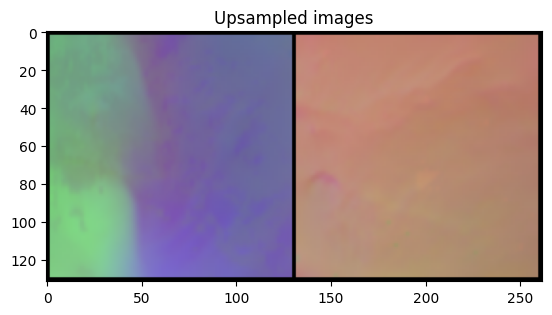

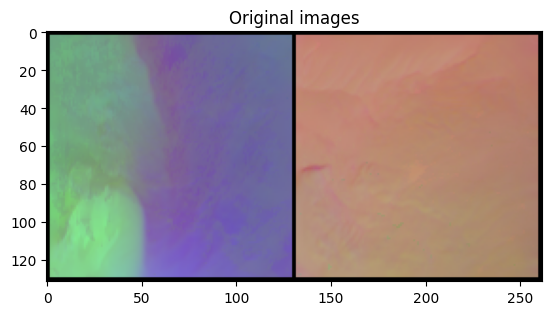

In [16]:
import matplotlib.pyplot as plt
import math
import torchvision

image_batch = next(generator)
plt.title("Upsampled images")
low_resolution_images = image_batch['low_resolution_images']
low_resolution_images = postprocess_image(low_resolution_images)
batch_size, _, _, _ = low_resolution_images.shape
nrow = int(math.ceil(math.sqrt(batch_size)))
grid = torchvision.utils.make_grid(low_resolution_images, nrow=nrow).permute(1, 2, 0)
grid = grid.data.numpy().astype(np.uint8)
plt.imshow(grid)
plt.show()

plt.title("Original images")
high_resolution_images = image_batch['high_resolution_images']
high_resolution_images = postprocess_image(high_resolution_images)
batch_size, _, _, _ = high_resolution_images.shape
nrow = int(math.ceil(math.sqrt(batch_size)))
grid = torchvision.utils.make_grid(high_resolution_images, nrow=nrow).permute(1, 2, 0)
grid = grid.data.numpy().astype(np.uint8)
plt.imshow(grid)
plt.show()



В `get_coeffs_primities` - словарь с коэффицентами, при помощи которых вы сможете реализовать семплирование из распределений $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$.

`extract_values_from_times` - по батчу с целочислненными временами выдает батч коэфиицентов в нужном шейпе для перемножения с батчом картинок


In [27]:
from torch import nn


def get_coeffs_primitives(
    T: int = 1000,
    beta_min: float = 1e-4,
    beta_max: float = 2e-2,
) -> Dict[str, Tensor]:
    """
    output: Dict[str, Tensor]
      {
        "a": b
      }
    ---
    b.shape == (T,)
    """
    betas = torch.linspace(beta_min, beta_max, T).float()
    sqrt_betas = torch.sqrt(betas)
    alphas = 1 - betas

    sqrt_alphas = torch.sqrt(alphas)
    alphas_hat = torch.cumprod(alphas, dim=0)
    alphas_hat = torch.cumprod(alphas, dim=0)
    complement_alphas_hat = 1 - alphas_hat

    sqrt_alphas_hat = torch.sqrt(alphas_hat)
    sqrt_1m_alphas_hat = torch.sqrt(complement_alphas_hat)

    alphas_hat_prev = torch.cat([torch.FloatTensor([1.]), alphas_hat[:-1]])
    complement_alphas_hat_prev = 1 - alphas_hat_prev

    sqrt_alphas_hat_prev = torch.sqrt(alphas_hat_prev)
    sqrt_1m_alphas_hat_prev = torch.sqrt(complement_alphas_hat_prev)

    return {
        "betas": betas,
        "alphas": alphas,
        "alphas_hat": alphas_hat,
        "alphas_hat_prev": alphas_hat_prev,
        "complement_alphas_hat": complement_alphas_hat,
        "complement_alphas_hat_prev": sqrt_1m_alphas_hat_prev,
        "sqrt_alphas": sqrt_alphas,
        "sqrt_alphas_hat": sqrt_alphas_hat,
        "sqrt_alphas_hat_prev": sqrt_alphas_hat_prev,
        "sqrt_1m_alphas_hat_prev": sqrt_1m_alphas_hat_prev,
        "sqrt_1m_alphas_hat": sqrt_1m_alphas_hat
    }


def extract_values_from_times(values: Tensor, times: torch.LongTensor) -> Tensor:
    values = values[times]
    return values[:, None, None, None]


In [28]:
class DDPMDynamic(nn.Module):
    def __init__(
        self,
        T: int = 1000,
        beta_min: float = 1e-4,
        beta_max: float = 2e-2,
    ):
        super().__init__()
        self.T = T

        coeffs_primitives = get_coeffs_primitives(T, beta_min, beta_max)

        for name, tensor in coeffs_primitives.items():
            self.register_buffer(name, tensor)

    def sample_time_on_device(self, batch_size: int = 1, device: torch.device = torch.device('cpu')):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def sample_from_posterior_q(
        self,
        x_t: Tensor,
        x_0: Tensor,
        t: torch.LongTensor
    ) -> Tensor:

        complement_alphas_hat_prev = extract_values_from_times(self.complement_alphas_hat_prev, t)
        complement_alphas_hat = extract_values_from_times(self.complement_alphas_hat, t)
        sqrt_alphas_hat_prev = extract_values_from_times(self.sqrt_alphas_hat_prev, t)
        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        betas = extract_values_from_times(self.betas, t)

        return (
            ( sqrt_alphas_hat_prev * betas / complement_alphas_hat) * x_0 +
            ( sqrt_alphas_hat * complement_alphas_hat_prev / complement_alphas_hat) * x_t
        )

    def get_x_zero(
        self,
        x_t: Tensor,
        eps: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

        x_0 = (x_t - sqrt_1m_alphas_hat * eps) / sqrt_alphas_hat
        return x_0

    def forward(self, batch: Dict[str, Tensor]) -> Dict[str, Tensor]:
        """
            Dict:
                x_0 - clean_image
                time - time
                eps - optional pre-sampled noise
        Returns:
            Dict:
                x_t - noised_sample
                eps - corresponding noise
        """
        x_0 = batch['x_0']
        t = batch['time']

        if 'eps' in batch:
          eps = batch['eps']
        else:
          eps = torch.randn_like(x_0)

        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

        x_t = sqrt_alphas_hat * x_0 + sqrt_1m_alphas_hat * eps

        return {
            "x_t": x_t,
            "eps": eps,
        }


In [29]:
def check_ddpm_dynamic():
    dynamic = DDPMDynamic()

    if torch.cuda.is_available():
      device = torch.device('cuda:0')
    else:
      device = torch.device('cpu')

    dynamic.to(device)
    times = dynamic.sample_time_on_device(10, device)
    assert times.device == device, f'{times.device}, {device}'
    assert times.shape == (10,)

check_ddpm_dynamic()

In [30]:
from tqdm.auto import trange

class Sampler(nn.Module):
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic
    ):
        super().__init__()
        ddpm.eval()
        self.ddpm = ddpm
        self.dynamic = dynamic

    @torch.no_grad()
    def single_step(
        self,
        x_t: torch.Tensor,
        x_c: torch.Tensor,
        t: torch.LongTensor,
      ) -> Tensor:
        if t[0] == 0:
          z = torch.zeros_like(x_t)
        else:
          z = torch.randn_like(x_t)


        alphas_hat = extract_values_from_times(self.dynamic.alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.dynamic.sqrt_1m_alphas_hat, t)
        sqrt_alphas = extract_values_from_times(self.dynamic.sqrt_alphas, t)
        betas = extract_values_from_times(self.dynamic.betas, t)

        eps = self.ddpm(
           x=x_t,
           time=t,
           x_self_cond=x_c
        )

        x_t_1 = ( 1 / sqrt_alphas ) * ( x_t - ( betas / sqrt_1m_alphas_hat ) * eps ) + torch.sqrt(betas)*z

        return x_t_1

    @torch.no_grad()
    def sample(
        self,
        x_0: Tuple,
        x_c: torch.Tensor,
        device: torch.device = torch.device('cpu'),
        verbose: bool = False
    ) -> Tensor:
        self.ddpm.eval()
        x_t = torch.randn(x_0, device=device)
        batch_size = x_t.shape[0]

        bar = trange if verbose else range
        for t in bar(self.dynamic.T - 1, -1, -1):
            t_tensor = torch.ones(batch_size, dtype=torch.int64, device=device) * t
            x_t = self.single_step(x_t, x_c, t_tensor)
        return x_t


### Обучение ddpm.


In [31]:
from torch_ema import ExponentialMovingAverage
from torch.fft import rfft2
import wandb
import math
import torchvision


class DiffusionTrainer:
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        device: torch.device = torch.device('cpu')
    ):
        self.ddpm = ddpm
        self.dynamic = dynamic

        self.dynamic.to(device)
        self.ddpm.to(device)

        self.sampler = Sampler(ddpm, dynamic)
        self.sampler.to(device)

        self.ema = ExponentialMovingAverage(ddpm.parameters(), decay=0.999)

        self.device = device


        self.optimizer = torch.optim.AdamW(
            self.ddpm.parameters(),
            lr=2e-4,
            weight_decay=1e-2
        )

        self.step = 0

    def switch_to_ema(self) -> None:
        self.ema.store(self.ddpm.parameters())
        self.ema.copy_to(self.ddpm.parameters())

    def switch_back_from_ema(self) -> None:
        self.ema.restore(self.ddpm.parameters())

    def calc_loss(
            self,
            x_0: torch.Tensor,
            x_c: torch.Tensor,
        ) -> torch.Tensor:
        batch_size, C, H, W = x_0.shape

        t = torch.randint(
            low=0,
            high=self.dynamic.T,
            size=(batch_size,),
            device=self.device
        )

        batch = {
            'x_0': x_0,
            'time': t,
        }

        x_t_batch = self.dynamic(batch)

        x_t = x_t_batch['x_t'].to(self.device)
        eps = x_t_batch['eps'].to(self.device)

        eps_model = self.ddpm(
           x=x_t,
           time=t,
           x_self_cond=x_c
        )

        sqrt_1m_alphas_hat = extract_values_from_times(self.dynamic.sqrt_1m_alphas_hat, t)
        betas = extract_values_from_times(self.dynamic.betas, t)

        x_0_model = ( x_t - ( betas / sqrt_1m_alphas_hat ) * eps_model )
        x_0_gt = ( x_t - ( betas / sqrt_1m_alphas_hat ) * eps )

        f_x_0_model = ( 2**(1/2) / H ) * rfft2(x_0_model)
        f_x_0_gt = ( 2**(1/2) / H ) * rfft2(x_0_gt)

        spectr_x_0_model = (
            torch.pow(f_x_0_model.real, 2) +
            torch.pow(f_x_0_model.imag, 2)
        )

        spectr_x_0_gt = (
            torch.pow(f_x_0_gt.real, 2) +
            torch.pow(f_x_0_gt.imag, 2)
        )

        return  torch.nn.functional.mse_loss(eps_model, eps) + \
         (torch.abs(spectr_x_0_model - spectr_x_0_gt)).mean()

    def log_metric(self, metric_name: str, loader_name: str, value: Union[float, torch.Tensor, wandb.Image]):
        wandb.log({f'{metric_name}/{loader_name}': value}, step=self.step)

    def optimizer_logic(self, loss: torch.Tensor) -> None:
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.ema.update(self.ddpm.parameters())

    def train(
            self,
            train_generator: Generator[Dict[str, Tensor], None, None],
            total_iters: int = 1000,
            project_name: str = 'discrete_time_ddpm',
            experiment_name: str = 'mnist_baseline'
        ) -> None:
        session = wandb.init(project=project_name, name=experiment_name)

        self.ddpm.train()

        for iter_idx in trange(1, 1 + total_iters):
            self.step = iter_idx

            image_batch = next(train_generator)

            if iter_idx % 1000 == 0:
                self.snapshot(x_c=image_batch['low_resolution_images'].to(device))

            low_resolution_images_means = image_batch['low_resolution_images'].mean(
              dim=(2, 3),
              keepdim=True
            )

            low_resolution_images_std = image_batch['low_resolution_images'].std(
              dim=(2, 3),
              keepdim=True
            )

            image_batch['high_resolution_images'] = (
                image_batch['high_resolution_images'] -
                low_resolution_images_means
            ) / low_resolution_images_std

            image_batch['low_resolution_images'] = (
                image_batch['low_resolution_images'] -
                low_resolution_images_means
            ) / low_resolution_images_std


            image_batch = dict_to_device(image_batch, device=self.device)

            loss = self.calc_loss(
              x_0=image_batch['high_resolution_images'],
              x_c=image_batch['low_resolution_images']
            )

            self.log_metric('mse', 'train', loss)

            self.optimizer_logic(loss)


        self.ddpm.eval()
        self.switch_to_ema()

        session.finish()

    @torch.no_grad()
    def sample_images(
            self,
            x_c: torch.Tensor,
            verbose: bool = False
    ) -> torch.Tensor:

        x_c_means = x_c.mean(
          dim=(2, 3),
          keepdim=True
        )

        x_c_std = x_c.std(
          dim=(2, 3),
          keepdim=True
        )

        x_pred = self.sampler.sample(
            x_0=x_c.shape,
            x_c=(x_c - x_c_means) / x_c_std,
            device=self.device,
            verbose=verbose,
        )

        x_pred = postprocess_image( x_pred * x_c_std + x_c_means )
        return x_pred

    @torch.no_grad()
    def snapshot(self, x_c: torch.Tensor) -> None:
        prev_mode = self.ddpm.training

        self.ddpm.eval()
        self.switch_to_ema()

        images = self.sample_images(x_c=x_c).cpu()
        nrow = 10
        grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
        grid = grid.data.numpy().astype(np.uint8)
        self.log_metric('images', 'from_noise', wandb.Image(grid))

        self.switch_back_from_ema()
        self.ddpm.train(prev_mode)

In [32]:
from denoising_diffusion_pytorch import Unet

ddpm = Unet(
    dim=32,
    dim_mults=(1, 2, 4, 4),
    channels=3,
    self_condition=True,
    flash_attn=True
)
device = torch.device('cuda:0')
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device
)
generator = get_images_generator(
  dataset=WeatherFieldsDataset(train=True),
  batch_size=32
)

3it [00:00,  5.48it/s]


In [ ]:
trainer.train(
    generator,
    total_iters=10000
)

mse/train,█▂▂▂▂▂▁▁▂▂▂▁▂▁▂▁▁▂▂▂▂▁▁▁▁▁▂▁▂▁▁▁▂▂▂▁▁▁▂▁
mse/train,0.09254


  0%|          | 0/10000 [00:00<?, ?it/s]

#### Безусловная генерация

3it [00:01,  1.99it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

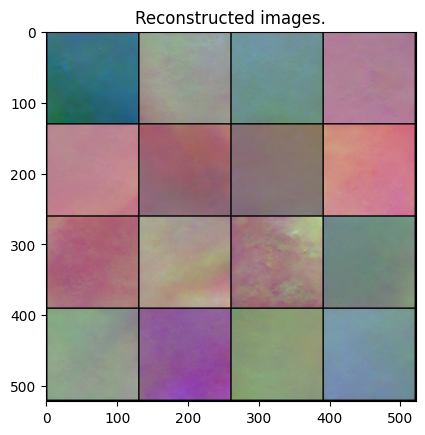

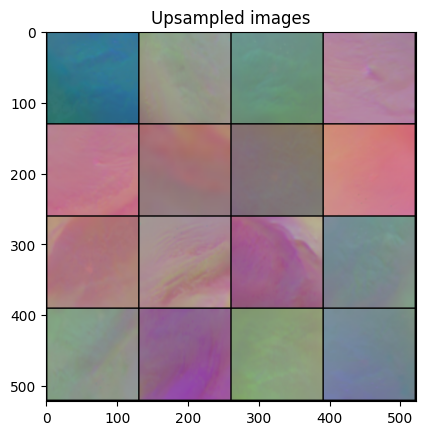

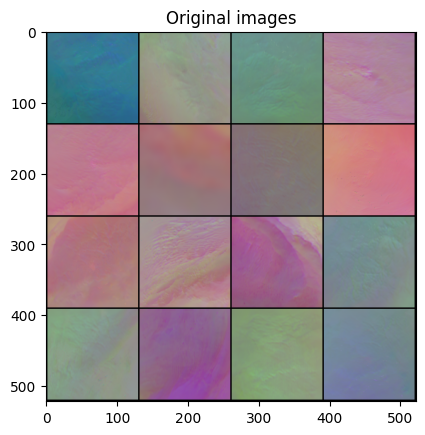

In [26]:
from matplotlib import pyplot as plt
import math


def sample_images(
    sampler: Sampler,
    x_c: torch.Tensor,
    device = torch.device('cuda:0'),
    verbose: bool = True,
):
    batch_size, _, _, _ = x_c.shape

    x_c_means = x_c.mean(
      dim=(2, 3),
      keepdim=True
    )

    x_c_std = x_c.std(
      dim=(2, 3),
      keepdim=True
    )

    images = sampler.sample(
        x_0=x_c.shape,
        x_c=(x_c - x_c_means) / x_c_std,
        device=device,
        verbose=verbose,
    )

    images = postprocess_image(images * x_c_std + x_c_means)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid

device = torch.device('cuda:0')
generator = get_images_generator(
    dataset=WeatherFieldsDataset(train=True),
    batch_size=16
)
image_batch = next(generator)
x_c = image_batch['low_resolution_images'].to(device)

grid = sample_images(
    sampler=trainer.sampler,
    x_c=x_c,
    device=trainer.device,
)

plt.title("Reconstructed images.")
plt.imshow(grid)
plt.show()

plt.title("Upsampled images")
low_resolution_images = image_batch['low_resolution_images']
low_resolution_images = postprocess_image(low_resolution_images)
batch_size, _, _, _ = low_resolution_images.shape
nrow = int(math.ceil(math.sqrt(batch_size)))
grid = torchvision.utils.make_grid(low_resolution_images, nrow=nrow).permute(1, 2, 0)
grid = grid.data.numpy().astype(np.uint8)
plt.imshow(grid)
plt.show()

plt.title("Original images")
high_resolution_images = image_batch['high_resolution_images']
high_resolution_images = postprocess_image(high_resolution_images)
batch_size, _, _, _ = high_resolution_images.shape
nrow = int(math.ceil(math.sqrt(batch_size)))
grid = torchvision.utils.make_grid(high_resolution_images, nrow=nrow).permute(1, 2, 0)
grid = grid.data.numpy().astype(np.uint8)
plt.imshow(grid)
plt.show()